# Setup

In [ ]:
%%capture
!pip install ta
!pip install yfinance

In [ ]:
import gc
import os
import sys
import math
import time
import random
import pprint

import ta
import numpy as np
import pandas as pd
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
SEED = 42

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
pd.options.mode.chained_assignment = None

plt.style.use('seaborn')

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [ ]:
!nvidia-smi

Tue Apr 12 06:16:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    15W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Create a function to plot time series data
def plot_time_series(data_to_plot, xticks_interval=90, ylabel="Price"):
    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    plt.plot(data_to_plot.index,
            data_to_plot['Close'], color='black', label='Close')

    # make x ticks nice
    xticks = [data_to_plot.index[i] if ((i % xticks_interval == 0 and (
        data_to_plot.shape[0]-i) > xticks_interval) or i == data_to_plot.shape[0]-1) else None for i in range(data_to_plot.shape[0])]
    x = np.arange(0, len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    
    plt.xlabel("Date")
    plt.ylabel(ylabel)

    plt.grid(False)
    plt.show()


In [ ]:
def create_dataset(ticker, start_date, end_date):
    """Download data from yFinance and store it as a csv file
    """
    data = yf.download(
        tickers=ticker,
        start=start_date,
        end=end_date,
        interval='1h',
        actions=False,
        prepost=True,
        auto_adjust=True,
        back_adjust=True,
        index_as_date=True,
        threads=True,
    )
    return data

In [ ]:
def calculate_metrics(actual, prediction):
    print(
        {   'mae' : format(mean_absolute_error(actual, prediction), '.4f'),
            'rmse' : format(mean_squared_error(actual, prediction) ** 0.5, '.4f'),
            'r2' : format(r2_score(actual, prediction), '.4f')
        }
    )

# Hyperparameters

In [ ]:
HORIZON = 1 # predict x steps at a time
WINDOW_SIZE = 96  # use the last x hours to predict the next

TEST_SIZE = 0.2  # use the last 20% of the data as test data

EPOCHS = 50
LR = 0.001

HIDDEN_DIM = 16
NUM_LAYERS = 3

# Get the Data

In [ ]:
# Get the data
ticker = "BTC-EUR"
start_date = '2020-05-01'
end_date = '2022-03-31'
path_to_csv = os.path.join(".", ticker + "-hourly.csv")

if not os.path.exists(path_to_csv):
    df = create_dataset(ticker, start_date, end_date)
    df.to_csv(path_to_csv)
    
df = pd.read_csv(path_to_csv)
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df = df.set_index('Date')

df

,Open,High,Low,Close,Volume
Date,,,,,
2020-05-01 00:00:00+00:00,7919.458008,8011.712891,7919.458008,7981.766113,0
2020-05-01 01:00:00+00:00,7986.103027,8026.972168,7965.565430,7966.056152,0
2020-05-01 02:00:00+00:00,7966.387207,8002.230469,7961.483887,8000.551758,0
2020-05-01 03:00:00+00:00,8000.727051,8009.870117,7962.763672,7963.717773,0
2020-05-01 04:00:00+00:00,7963.717773,8022.688965,7960.450684,8022.688965,0
...,...,...,...,...,...
2022-03-30 19:00:00+00:00,42398.960938,42398.960938,42068.750000,42173.929688,173043712
2022-03-30 20:00:00+00:00,42175.152344,42305.964844,42168.855469,42305.964844,189313024
2022-03-30 21:00:00+00:00,42303.511719,42348.859375,42087.792969,42087.792969,24156160


In [ ]:
%%capture
# Apply technicals
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

In [ ]:
df.head(3)

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:00+00:00,7919.458008,8011.712891,7919.458008,7981.766113,0,0.0,0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,7981.766113,-72.942054,0.000000,0.000000
2020-05-01 01:00:00+00:00,7986.103027,8026.972168,7965.565430,7966.056152,0,0.0,0,0.0,-0.0,0.0,...,-0.015703,-0.003141,-0.012563,0.0,0.0,0.0,7974.766637,-0.196823,-0.197017,-0.196823
2020-05-01 02:00:00+00:00,7966.387207,8002.230469,7961.483887,8000.551758,0,0.0,0,0.0,-0.0,0.0,...,0.006652,-0.001182,0.007834,0.0,0.0,0.0,7986.291974,0.433032,0.432098,0.235357


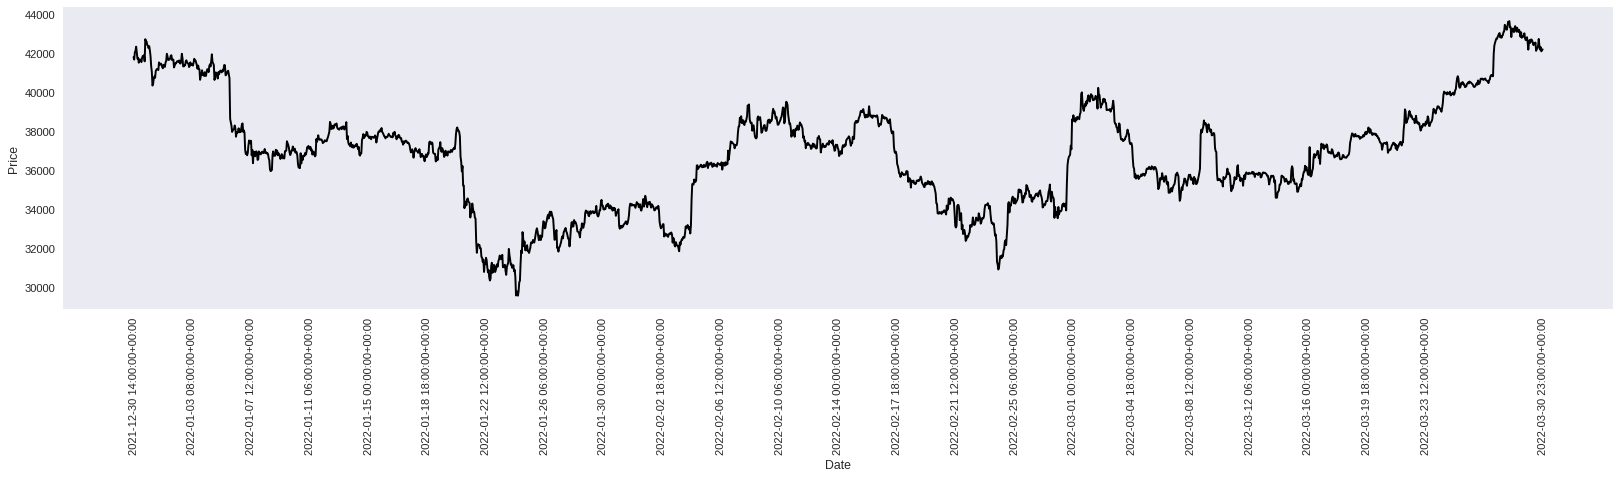

In [ ]:
lockback_period = 2160
data_to_plot = df.copy().tail(lockback_period)
plot_time_series(data_to_plot)

# Data preparation

## Normalizing close price data

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [ ]:
df_scaler = MinMaxScaler(feature_range=(-1, 1))
arr_scaled = df_scaler.fit_transform(df)

df_scaled = pd.DataFrame(arr_scaled, columns=df.columns,index=df.index)
df_scaled['Close'] = df['Close'].values

In [ ]:
df_scaled.tail(5)

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-30 19:00:00+00:00,0.337632,0.334091,0.328454,0.328253,-1.0,-0.194149,-0.655751,0.114038,-0.914895,-0.671837,...,-0.017918,-0.048404,0.126770,-0.128626,-0.239167,-0.474107,0.363838,0.214737,-0.014671,0.328253
2022-03-30 20:00:00+00:00,0.329012,0.330506,0.332318,0.333340,-1.0,-0.194148,-0.655751,0.164263,-0.914895,-0.670234,...,-0.017549,-0.048310,0.127514,-0.107011,-0.212799,-0.479088,0.363616,0.228905,0.007574,0.333340
2022-03-30 21:00:00+00:00,0.333956,0.332160,0.329189,0.324935,-1.0,-0.194148,-0.655751,0.435178,-0.914895,-0.670756,...,-0.025906,-0.050066,0.109851,-0.171120,-0.204530,-0.555057,0.362902,0.215002,-0.014252,0.324935
2022-03-30 22:00:00+00:00,0.325808,0.324650,0.326962,0.327486,-1.0,-0.194148,-0.655751,0.298307,-0.914895,-0.670756,...,-0.028776,-0.052099,0.107203,-0.242689,-0.212233,-0.622097,0.362295,0.226293,0.003487,0.327486
2022-03-30 23:00:00+00:00,0.328176,0.328971,0.331724,0.328883,-1.0,-0.194149,-0.655751,0.155322,-0.914895,-0.670035,...,-0.028594,-0.053686,0.111467,-0.204742,-0.210804,-0.583765,0.362151,0.225096,0.001612,0.328883


##  Generating training and validation datasets

In [ ]:
gc.collect()

112350

In [ ]:
def make_windowed_dataset(data, window_size, horizon):
    """
    Create a dataset of windowed data
    """
    X = []
    Y = []
    
    data_y = data[['Close']]
    data_x = data.drop(columns=['Close'])
    
    for i in range(len(data) - window_size - horizon + 1):
        x = data_x[i:i + window_size].values
        y = data_y[i + window_size:i + window_size + horizon].values[-1]
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)

In [ ]:
features, labels = make_windowed_dataset(df_scaled, WINDOW_SIZE, HORIZON)

In [ ]:
labels= labels.reshape(-1)

In [ ]:
features[-1].shape, labels[-1].shape

((96, 90), ())

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=TEST_SIZE, shuffle=False, random_state=SEED)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((13036, 96, 90), (3260, 96, 90), (13036,), (3260,))

In [ ]:
x_test[-1][WINDOW_SIZE-1:], y_test[-1]

(array([[ 0.32580827,  0.32465014,  0.32696162, -1.        , -0.19414846,
         -0.65575117,  0.29830689, -0.91489501, -0.67075647, -0.54637659,
         -0.83543918,  0.4427788 , -0.06177847, -0.99913399,  0.36754008,
          0.33997115,  0.38349296, -0.86968715, -0.2907535 , -1.        ,
         -1.        ,  0.35442946,  0.34400333,  0.3548569 , -0.87209996,
         -0.38288806, -1.        , -1.        ,  0.38409471,  0.34710467,
          0.36530266, -0.93117341, -0.68255493, -0.83904738, -0.8233496 ,
          0.07693428,  0.05579513,  0.17266347,  0.35531511,  0.37098296,
          0.35618686,  0.37124466, -0.0135043 ,  0.10226284, -0.17038469,
          0.98229736,  0.61985918, -0.24967491,  0.61039442,  0.6252603 ,
         -0.49972639,  0.35924916,  0.3665627 ,  0.36390616,  0.39268701,
         -0.67837514, -0.42079588, -0.54681422, -0.19962876, -0.08921963,
          0.38772947,  0.36733476, -0.91666667,  0.91666667, -0.91666667,
          0.43911905,  0.43139116, -1.

In [ ]:
df_scaled.tail(5)

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-30 19:00:00+00:00,0.337632,0.334091,0.328454,0.328253,-1.0,-0.194149,-0.655751,0.114038,-0.914895,-0.671837,...,-0.017918,-0.048404,0.126770,-0.128626,-0.239167,-0.474107,0.363838,0.214737,-0.014671,0.328253
2022-03-30 20:00:00+00:00,0.329012,0.330506,0.332318,0.333340,-1.0,-0.194148,-0.655751,0.164263,-0.914895,-0.670234,...,-0.017549,-0.048310,0.127514,-0.107011,-0.212799,-0.479088,0.363616,0.228905,0.007574,0.333340
2022-03-30 21:00:00+00:00,0.333956,0.332160,0.329189,0.324935,-1.0,-0.194148,-0.655751,0.435178,-0.914895,-0.670756,...,-0.025906,-0.050066,0.109851,-0.171120,-0.204530,-0.555057,0.362902,0.215002,-0.014252,0.324935
2022-03-30 22:00:00+00:00,0.325808,0.324650,0.326962,0.327486,-1.0,-0.194148,-0.655751,0.298307,-0.914895,-0.670756,...,-0.028776,-0.052099,0.107203,-0.242689,-0.212233,-0.622097,0.362295,0.226293,0.003487,0.327486
2022-03-30 23:00:00+00:00,0.328176,0.328971,0.331724,0.328883,-1.0,-0.194149,-0.655751,0.155322,-0.914895,-0.670035,...,-0.028594,-0.053686,0.111467,-0.204742,-0.210804,-0.583765,0.362151,0.225096,0.001612,0.328883


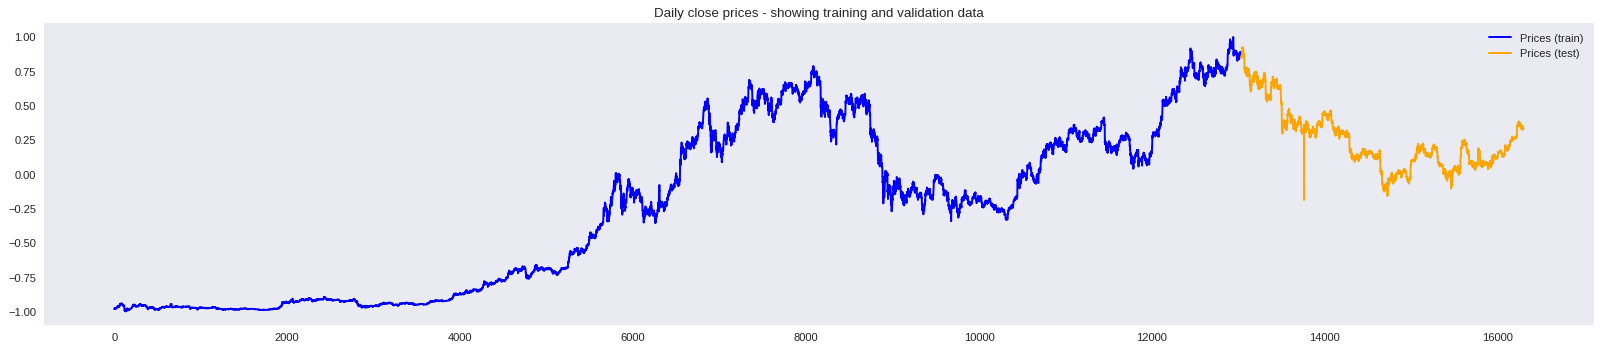

In [ ]:
# prepare data for plotting
to_plot_data_y_train = np.zeros(np.concatenate((y_train, y_test)).shape[0])
to_plot_data_y_test = np.zeros(np.concatenate((y_train, y_test)).shape[0])

to_plot_data_y_train[:y_train.reshape(-1).shape[0]] = y_train.reshape(-1)
to_plot_data_y_test[y_train.reshape(-1).shape[0]:] = y_test.reshape(-1)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## plots
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(to_plot_data_y_test,
         label="Prices (test)", color='orange')

plt.title("Daily close prices - showing training and validation data")
plt.grid(False)
plt.legend()
plt.show()


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


dataset_train = TimeSeriesDataset(x_train, y_train)
dataset_test = TimeSeriesDataset(x_test, y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (13036, 96, 90) (13036,)
Test data shape (3260, 96, 90) (3260,)


# Model

## Create Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob = 0):
        super(LSTM, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out).reshape(-1)

        return out

In [ ]:
input_dim = x_train.shape[2]
hidden_dim = HIDDEN_DIM
num_layers = NUM_LAYERS
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
print(model)

LSTM(
  (lstm): LSTM(90, 16, num_layers=3, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


## Model Training

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=256, shuffle=True)

In [ ]:
num_epochs = EPOCHS
print_every = 10
train_losses = []

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim).to(device)
model.train()

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(num_epochs+1):
    epoch_loss = 0
    start_time = time.time()

    for (inputs, labels) in train_dataloader:
        # Step 1: Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        optimizer.zero_grad()

        # Step 2: Get our inputs ready for the network
        batchsize = inputs.shape[0]
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Step 3: Run forward pass
        outputs = model(inputs)
        outputs = outputs.reshape(-1)

        # Step 4: Compute the loss, gradients, and update the parameters
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    train_losses.append(epoch_loss)
    epoch_time = (time.time() - start_time) * 10

    if epoch % print_every == 0 and epoch > 0:
        print('Epoch[{}/{}] | T: {:.2f} | train loss:{:.8f}'.format(epoch, num_epochs, epoch_time, epoch_loss))

Epoch[10/50] | T: 9.75 | train loss:0.00007848
Epoch[20/50] | T: 9.85 | train loss:0.00004802
Epoch[30/50] | T: 9.96 | train loss:0.00003657
Epoch[40/50] | T: 9.97 | train loss:0.00003115
Epoch[50/50] | T: 9.83 | train loss:0.00003054


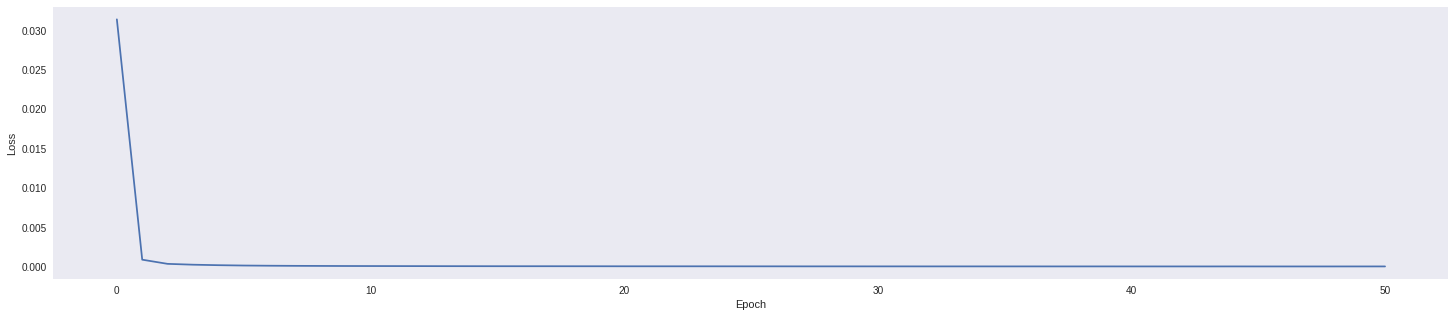

In [ ]:
fig = figure(figsize=(25, 5))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.grid(False)
plt.show()

## Model Evaluation

In [ ]:
# Set shuffle to false
train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=128, shuffle=False)

In [ ]:
model.eval()

LSTM(
  (lstm): LSTM(90, 16, num_layers=3, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
predicted_train = np.array([])
with torch.no_grad():
    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        out = model(x)
        out = out.cpu().detach().numpy().reshape(-1)
        predicted_train = np.concatenate((predicted_train, out))

In [ ]:
predicted_test = np.array([])
with torch.no_grad():
    for idx, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        out = model(x)
        out = out.cpu().detach().numpy().reshape(-1)
        predicted_test = np.concatenate((predicted_test, out))

In [ ]:
predicted_train.shape, predicted_test.shape, dataset_train.y.shape[0], dataset_test.y.shape[0]

((13036,), (3260,), 13036, 3260)

In [ ]:
predicted_train

array([-0.97734374, -0.97749496, -0.97760731, ...,  0.88665849,
        0.8908729 ,  0.88407904])

In [ ]:
predicted_train = scaler.inverse_transform(predicted_train.reshape(-1, 1)).reshape(-1)
predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1)).reshape(-1)

predicted_train.shape, predicted_test.shape

((13036,), (3260,))

In [ ]:
actual_train = scaler.inverse_transform(dataset_train.y.reshape(-1, 1)).reshape(-1)
actual_test = scaler.inverse_transform(dataset_test.y.reshape(-1, 1)).reshape(-1)

actual_train.shape, actual_test.shape

((13036,), (3260,))

In [ ]:
print("Train Results:")
calculate_metrics(actual_train, predicted_train)

Train Results:
{'mae': '216.9857', 'rmse': '318.5256', 'r2': '0.9996'}


In [ ]:
print("Test Results:")
calculate_metrics(actual_test, predicted_test)

Test Results:
{'mae': '298.0748', 'rmse': '464.6284', 'r2': '0.9934'}


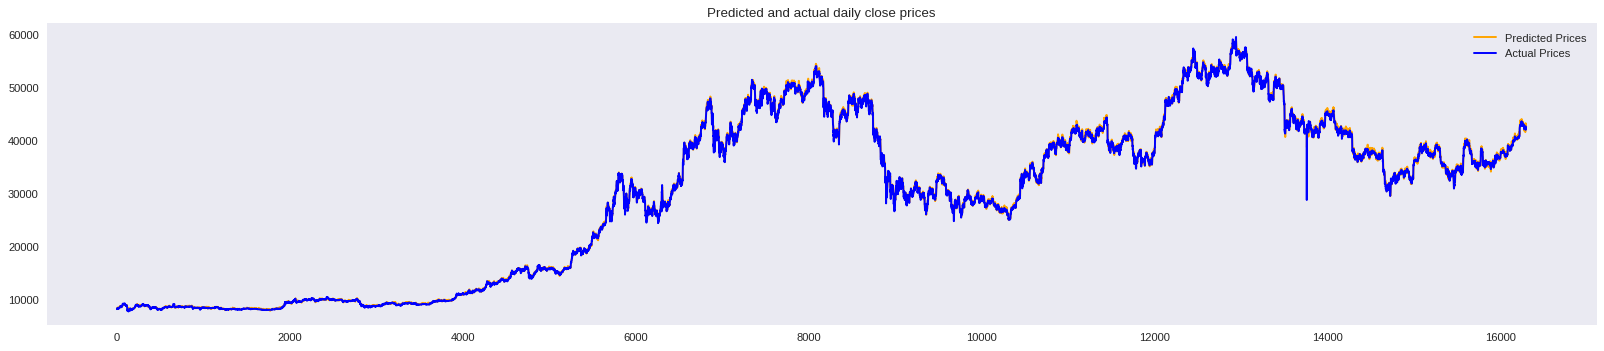

In [ ]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(np.concatenate((predicted_train, predicted_test)), label="Predicted Prices", color='orange')
plt.plot(np.concatenate((actual_train, actual_test)), label="Actual Prices", color='blue')

plt.title("Predicted and actual daily close prices")
plt.grid(False)
plt.legend()
plt.show()


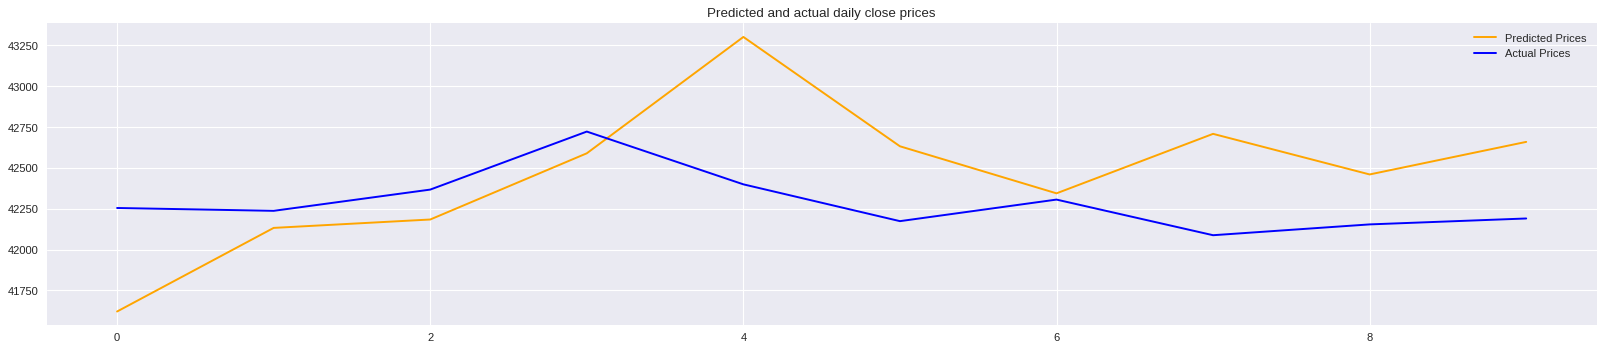

In [ ]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(np.concatenate((predicted_train, predicted_test))[-10:], label="Predicted Prices", color='orange')
plt.plot(np.concatenate((actual_train, actual_test))[-10:], label="Actual Prices", color='blue')

plt.title("Predicted and actual daily close prices")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame(data={"actual": actual_test[-10:], "prediction": predicted_test[-10:], "diff": actual_test[-10:] -  predicted_test[-10:]})

,actual,prediction,diff
0,42254.496094,41620.758374,633.737720
1,42237.109375,42132.609786,104.499589
2,42367.144531,42183.980892,183.163639
3,42722.371094,42589.324361,133.046733
4,42399.292969,43301.715554,-902.422585
5,42173.929688,42632.327009,-458.397322
6,42305.964844,42344.211589,-38.246746
7,42087.792969,42708.388861,-620.595892
8,42154.015625,42459.858466,-305.842841
9,42190.273438,42659.234800,-468.961363


### Test on April Data

In [ ]:
gc.collect()

8153

In [ ]:
# Get the data
ticker = "BTC-EUR"
start_date = '2022-04-01'
end_date = '2022-04-11'

stock_april = create_dataset(ticker, start_date, end_date)
stock_april.head(1)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
2022-04-01 00:00:00+00:00,41138.78125,41293.457031,41122.421875,41203.203125,0


In [ ]:
%%capture
stock = stock_april.copy()
stock = ta.add_all_ta_features(stock, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
stock['Close'] = scaler.fit_transform(stock['Close'].values.reshape(-1,1))

In [ ]:
stock_scaler = MinMaxScaler(feature_range=(-1, 1))
arr_scaled = stock_scaler.fit_transform(stock)

stock_scaled = pd.DataFrame(arr_scaled, columns=stock.columns,index=stock.index)
stock_scaled['Close'] = stock['Close'].values

In [ ]:
features, labels = make_windowed_dataset(stock, WINDOW_SIZE, HORIZON)
features.shape, labels.shape

((144, 96, 90), (144, 1))

In [ ]:
stock_predictions = np.array([])

for i in range(0, features.shape[0]):
    x = torch.Tensor(features[i]).expand(1, -1, -1)
    out = model(x.to(device))
    out = out.cpu().detach().numpy()
    stock_predictions = np.concatenate((stock_predictions, out.reshape(-1)))

In [ ]:
labels = scaler.inverse_transform(labels)
stock_predictions = scaler.inverse_transform(stock_predictions.reshape(-1, 1)).reshape(-1)

In [ ]:
print("Results:")
calculate_metrics(labels[-len(stock_predictions):], stock_predictions)

Results:
{'mae': '944.0215', 'rmse': '1261.2825', 'r2': '-0.1749'}


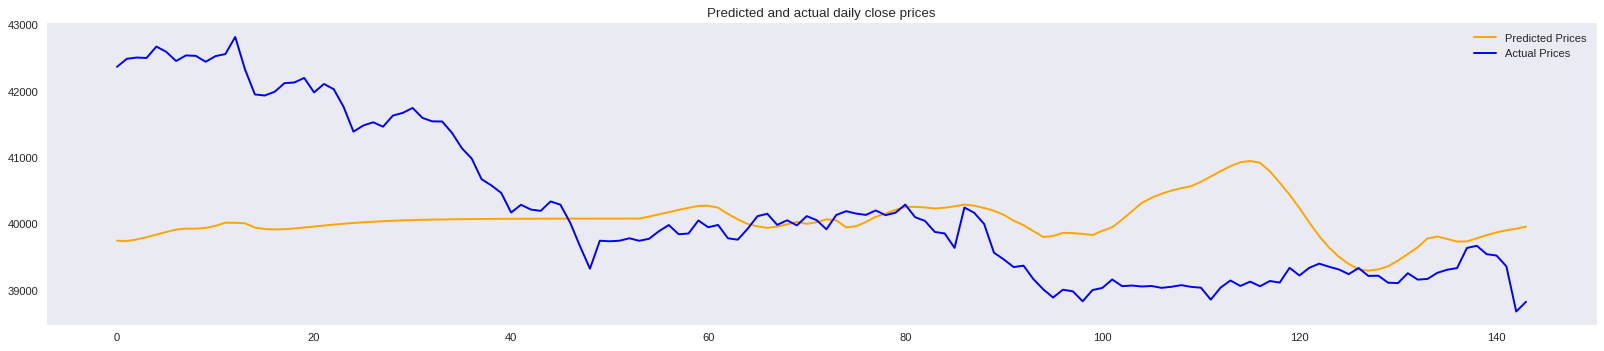

In [ ]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

plt.plot(stock_predictions, label="Predicted Prices", color='orange')
plt.plot(labels[-len(stock_predictions):], label="Actual Prices", color='blue')

plt.title("Predicted and actual daily close prices")
plt.grid(False)
plt.legend()
plt.show()

# Save the model

In [ ]:
model_path = os.path.join(".", "model.pt")
torch.save(model.state_dict(), model_path)